In [1]:
#IMPORT STUFF RELATED TO DATA MANAGEMENT
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
from cleanup_funcs import Cleanups

c = Cleanups()

limit = 'limit '+ str(500000)

In [2]:
# conn = sql.connect('NEST.sqlite') # poner el nest sin filtro de pandemia
conn = sql.connect('NEST.sqlite') # poner el nest sin filtro de pandemia

query = "SELECT IDEPOL, CODPOL, NUMPOL, NUMCERT, FECINIVALID, FECFINVALID, Dias_Expuesto, TIPOPDCION , TIPOVEH ,CODMARCA,CODMODELO,DESCMARCA, DESCMODELO, SUB_AGRUPADOR, ANOVEH, SEXO, FECNAC, SA_0001, SA_0002, SA_0003, SA_0004, SA_0005, SA_0107, SA_0108, CL_0001, CL_0002, CL_0003, CL_0004, CL_0005, CL_0107, CL_0108, ACT_0001, ACT_0002, ACT_0003, ACT_0004, ACT_0005, ACT_0107, ACT_0108, Claim_Count, KEY FROM NEST WHERE FECINIVALID >= '2010-01-01' " + limit
basico = pd.read_sql_query(query, conn)
basico["KEY2"] = basico["CODPOL"] + "_" + basico["NUMPOL"].astype(str) + "_" + basico["NUMCERT"].astype(str)

In [3]:
basico.columns

Index(['IDEPOL', 'CODPOL', 'NUMPOL', 'NUMCERT', 'FECINIVALID', 'FECFINVALID',
       'Dias_Expuesto', 'TIPOPDCION', 'TIPOVEH', 'CODMARCA', 'CODMODELO',
       'DESCMARCA', 'DESCMODELO', 'SUB_AGRUPADOR', 'ANOVEH', 'SEXO', 'FECNAC',
       'SA_0001', 'SA_0002', 'SA_0003', 'SA_0004', 'SA_0005', 'SA_0107',
       'SA_0108', 'CL_0001', 'CL_0002', 'CL_0003', 'CL_0004', 'CL_0005',
       'CL_0107', 'CL_0108', 'ACT_0001', 'ACT_0002', 'ACT_0003', 'ACT_0004',
       'ACT_0005', 'ACT_0107', 'ACT_0108', 'Claim_Count', 'KEY', 'KEY2'],
      dtype='object')

In [4]:
# limpiar columnas con cleanupfuncs y filtrarlas con lo acordado
#### todo tiene que estar filtrado del 2010 en adelante

# crear columna de año para poder usarla para medir inflacion en modelos
basico['FECINIVALID'] = pd.to_datetime(basico['FECINIVALID'], errors='coerce')
basico = basico[basico['FECINIVALID'].dt.year <= 2025]
basico['Ano'] = basico['FECINIVALID'].dt.year

# calcular edad del conductor cuando empezo la poliza
basico['EDADC'] = basico.apply(lambda row: c.calculate_age(row['FECNAC'], row['FECINIVALID']), axis=1)

# agrupador de sexoedad
basico["sexoedad"] = basico.apply(lambda x: c.sexo_edad(x["SEXO"], x["EDADC"]), axis = 1)

#### FILTROS A APLICAR
#solo P en de Particular y Produccion Propia
basico = basico[basico['TIPOPDCION'] == 'P']
basico = basico[basico['TIPOVEH'] == 'P']

#excluir 22B y 42B
basico = basico[~((basico['CODPOL'] == '22B') | (basico['CODPOL'] == '42B'))]

#eliminar flotas escondidas (usan 'CODMARCA'= 253 y 'CODMODELO'= 001)
basico = basico[(basico['CODMARCA'] != '253') | (basico['CODMODELO'] != '001')]

#Filtrar ASSAMOVIL
#basico['NUMPOL'] = pd.to_numeric(basico['NUMPOL'], errors='coerce')

# Filter out rows where 'NUMPOL' is 163040 and 'CODPOL' is '02B'
basico = basico.loc[(basico['NUMPOL'] != 163040) | (basico['CODPOL'] != '02B')]

# Filter out rows where 'NUMPOL' is 163040 and 'CODPOL' is '02B'
basico = basico.loc[(basico['NUMPOL'] != 11652) | (basico['CODPOL'] != '02B')]

#crear columna con suma de todos los CL
columns_to_sum = ['CL_0001', 'CL_0002', 'CL_0003', 'CL_0004', 'CL_0005', 'CL_0107', 'CL_0108']
basico['Total'] = basico[columns_to_sum].sum(axis=1)

#eliminar negativas del modelo
basico = basico[basico['Total'] >= 0]

# edad del vehiculo (pasar a cleanup funcs)
def calculate_vehicle_age(row):
    year_anoveh = row['ANOVEH']
    fecinivalid = row['FECINIVALID']

    if pd.isnull(fecinivalid):
        return np.nan
    try:
        year_fecinivalid = pd.to_datetime(fecinivalid).year
        veh_age = year_fecinivalid - year_anoveh
        return veh_age
    except (TypeError, ValueError):
        return np.nan


# Apply the function to create 'edad_veh' column
basico['edad_veh'] = basico.apply(calculate_vehicle_age, axis=1)

# sacar de basico edad de vehiculo menores a 0
basico = basico[basico['edad_veh'] >= 0]

# sacar de basico edad de conductor menores a 0
basico = basico[basico['EDADC'] >= 0]

# solo edad del vehiculo menor a 20
basico = basico[basico['edad_veh'] < 20]

# solo edad del conductor menor a 90
basico = basico[basico['EDADC'] < 90]

#Dias expuesto que sea de 0 a 1
basico['Dias_Expuesto'] = pd.to_numeric(basico['Dias_Expuesto'], errors='coerce') / 365.0

#edad veh as string
basico['edad_veh']= basico['edad_veh'].astype(str)
basico['Ano']= basico['Ano'].astype(str)

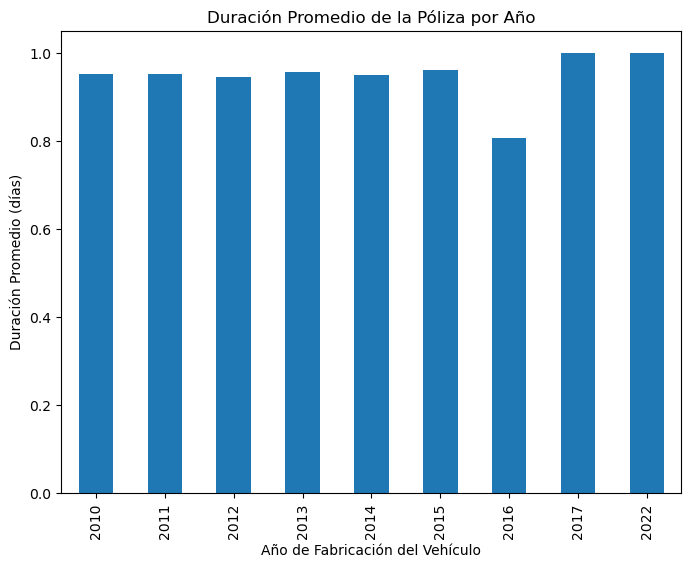

Duración Promedio de la Póliza por Cliente:
CODPOL
02B     0.940998
02BR    0.974578
Name: Dias_Expuesto, dtype: float64


In [5]:
# 1. Distribución de la duración de la póliza por año
duracion_por_año = basico.groupby('Ano')['Dias_Expuesto'].mean()

# Grafica la distribución de la duración de la póliza por año
plt.figure(figsize=(8, 6))
duracion_por_año.plot(kind='bar')
plt.title('Duración Promedio de la Póliza por Año')
plt.xlabel('Año de Fabricación del Vehículo')
plt.ylabel('Duración Promedio (días)')
plt.show()

# 2. Duración de la póliza por cliente (CODPOL)
duracion_por_cliente = basico.groupby('CODPOL')['Dias_Expuesto'].mean()

# Imprime la duración de la póliza por cliente
print("Duración Promedio de la Póliza por Cliente:")
print(duracion_por_cliente)


In [6]:
# Filtra los datos para un año específico (por ejemplo, 2022)
año = 2022
basico_año= basico[basico['ANOVEH'] == año]

# Calcula la cantidad de pólizas para el año específico
cantidad_por_año = basico_año.shape[0]

# Imprime la cantidad de pólizas para el año específico
print("Cantidad de Pólizas para el Año", año, ":", cantidad_por_año)


Cantidad de Pólizas para el Año 2022 : 1


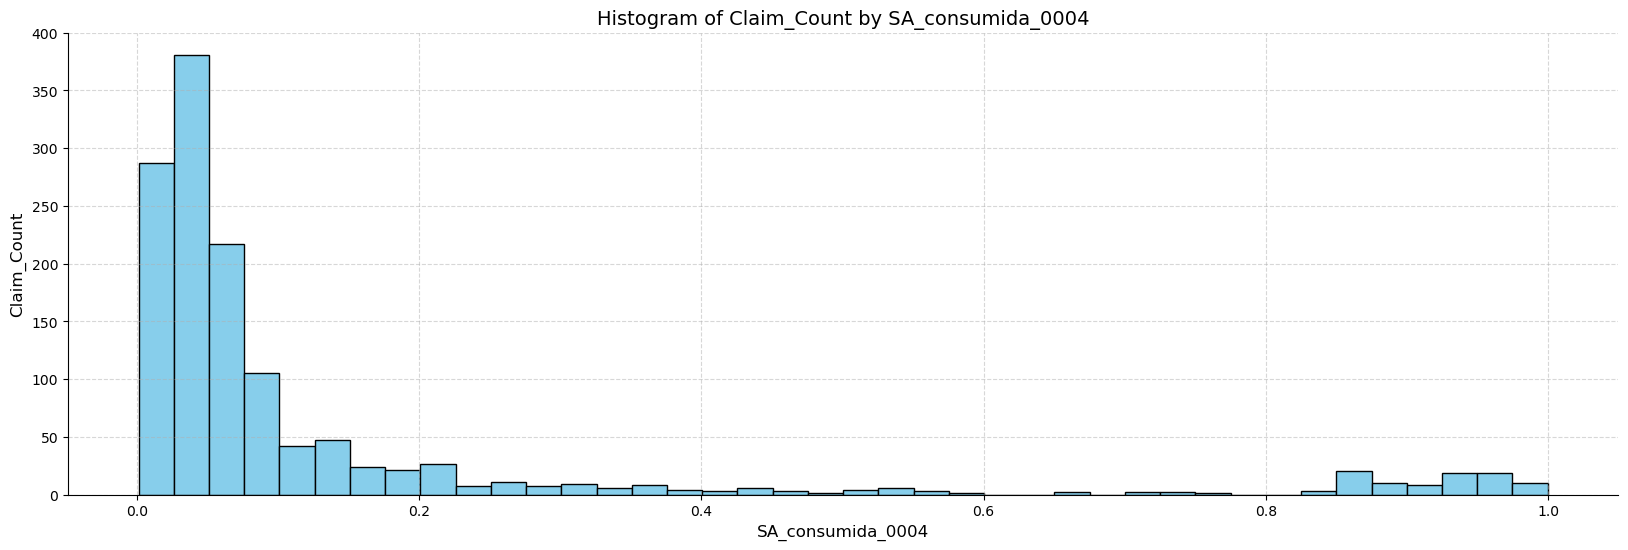

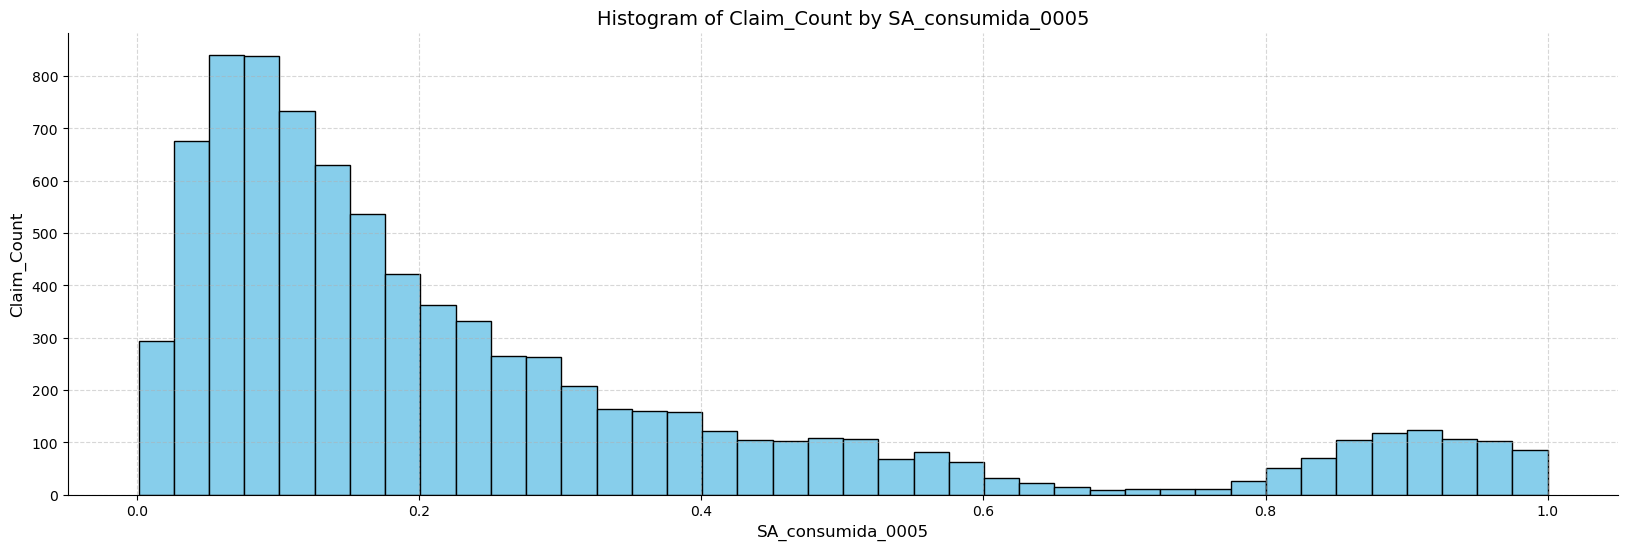

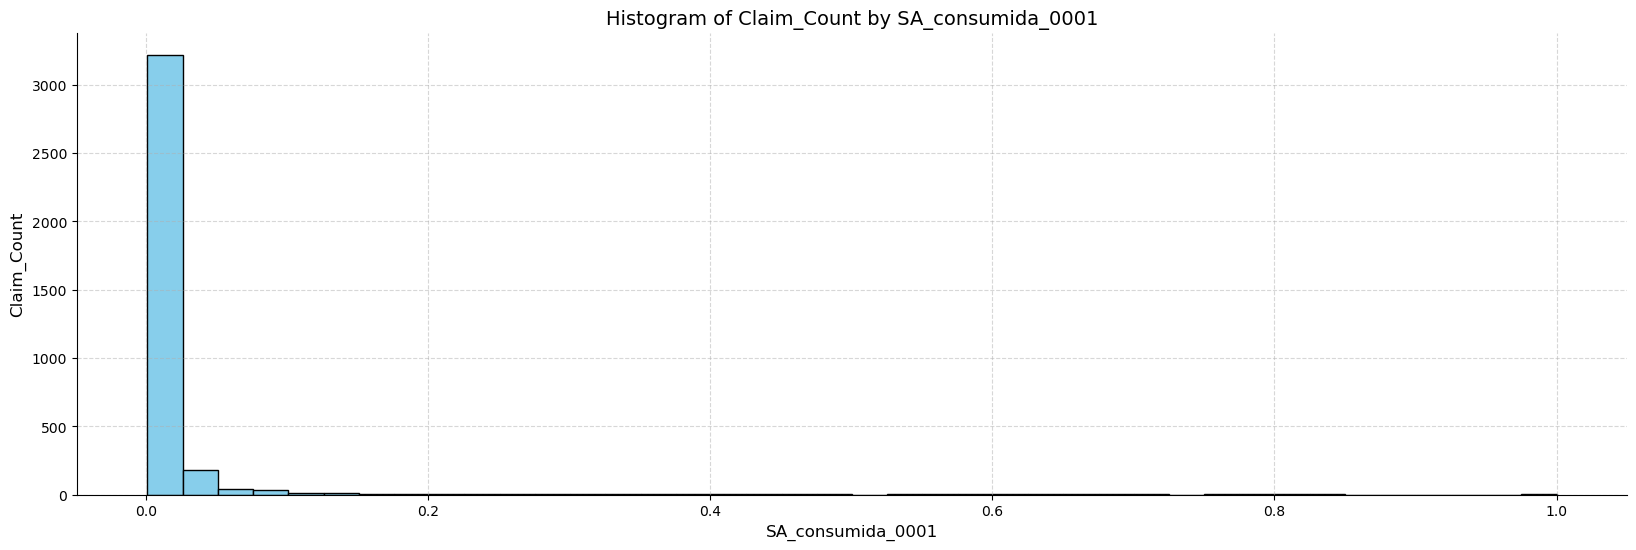

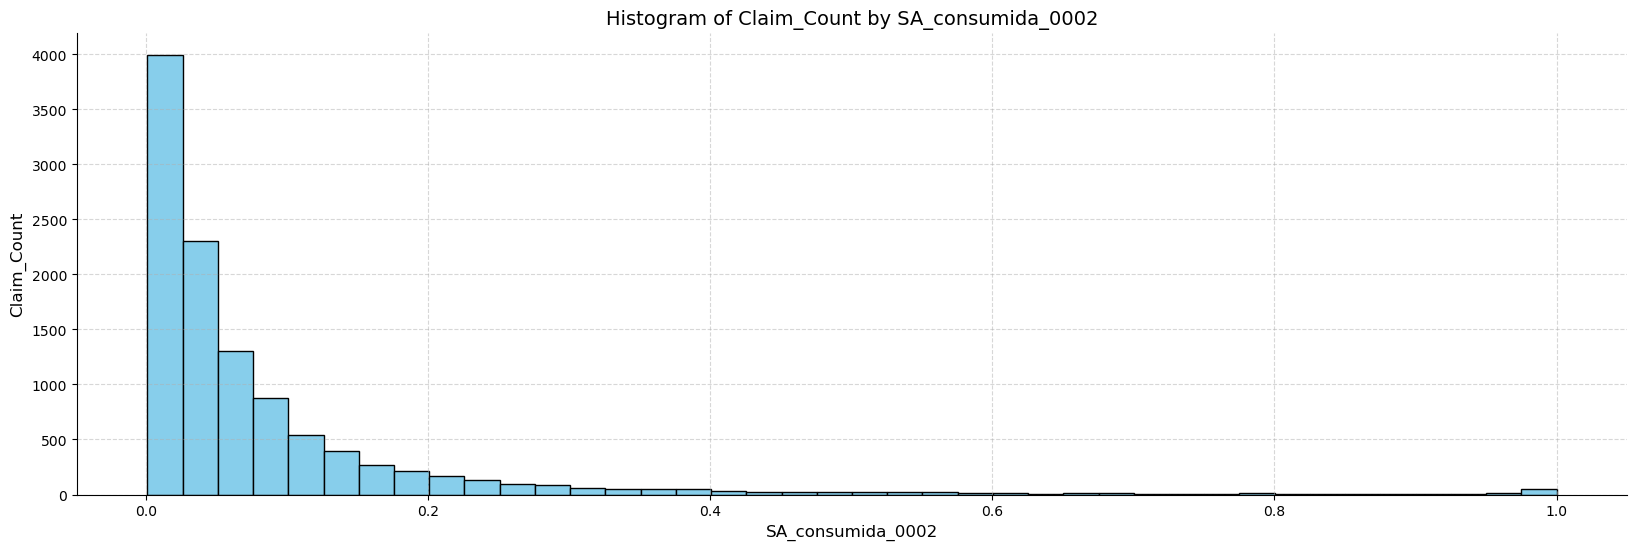

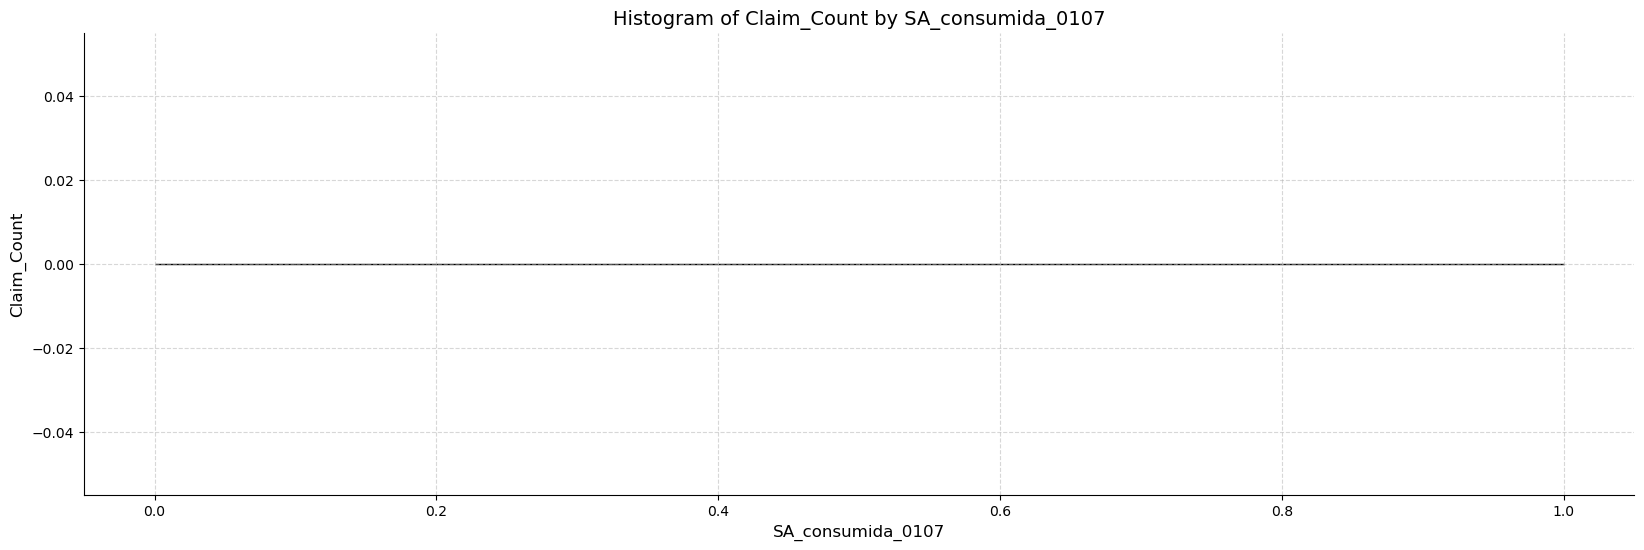

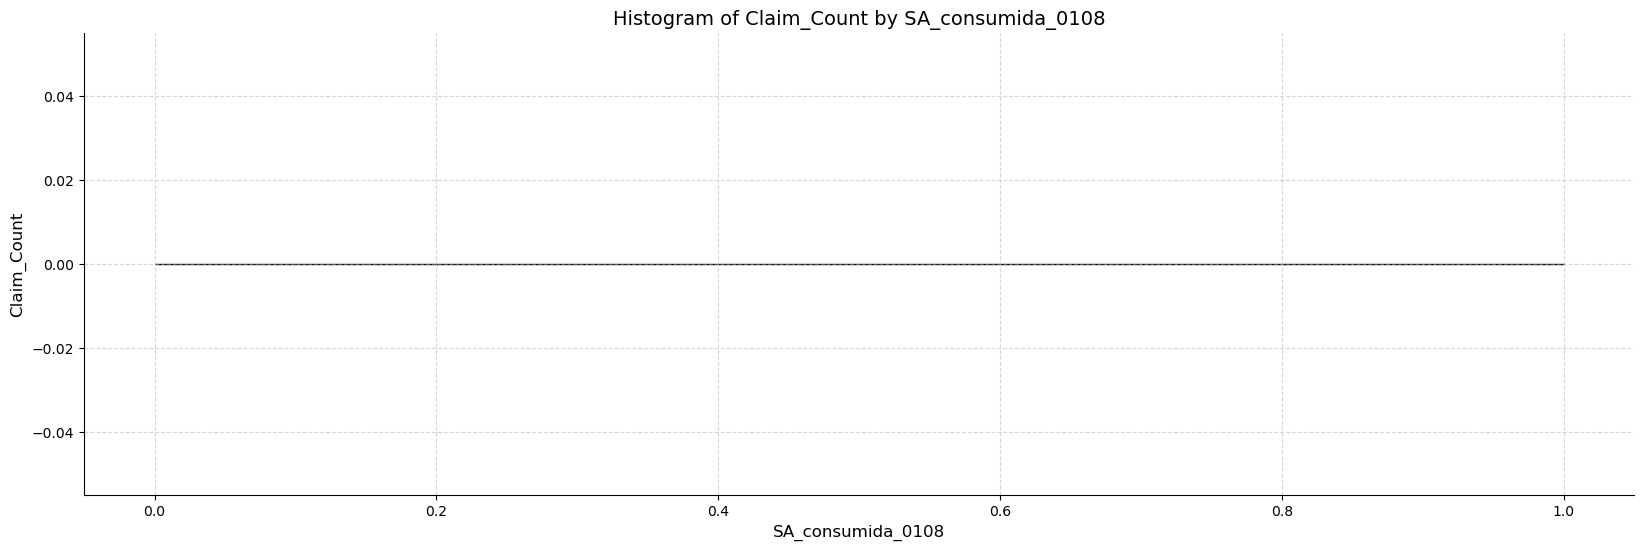

In [7]:
# histograms for loop
coberturas = ["0004", "0005", "0001", "0002", "0107", "0108"]

# Histogram 0004
c = 0
for c in coberturas:
    basico['SA_consumida_'+c+''] = basico['CL_'+c+''] / basico['SA_'+c+'']
    basico['SA_consumida_'+c+''] = basico['SA_consumida_'+c+''].fillna(0)
    basico['SA_consumida_'+c+''] = np.where(np.isinf(basico['SA_consumida_'+c+'']), 0, basico['SA_consumida_'+c+''])
    basico['SA_consumida_'+c+''].astype(str)
    basico['Claim_Count']
    basico['Claim_Count'] = basico['Claim_Count'].fillna(0) 

    # Filter out 0 values in 'SA_consumida_0005'
    filtered_data = basico[basico['SA_consumida_'+c+''] >= 0.001]

    # Filter out values greater than 100 in 'SA_consumida_0005'
    filtered_data = filtered_data[filtered_data['SA_consumida_'+c+''] <= 1]

    # Set up figure and axes
    fig, ax = plt.subplots(figsize=(20, 6))

    # Create histogram
    ax.hist(filtered_data['SA_consumida_'+c+''], bins=40, edgecolor='black', color='skyblue')

    # Set axis labels and title
    ax.set_xlabel('SA_consumida_'+c+'', fontsize=12)
    ax.set_ylabel('Claim_Count', fontsize=12)
    ax.set_title('Histogram of Claim_Count by SA_consumida_'+c+'', fontsize=14)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.5)

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the histogram
    plt.show()

        

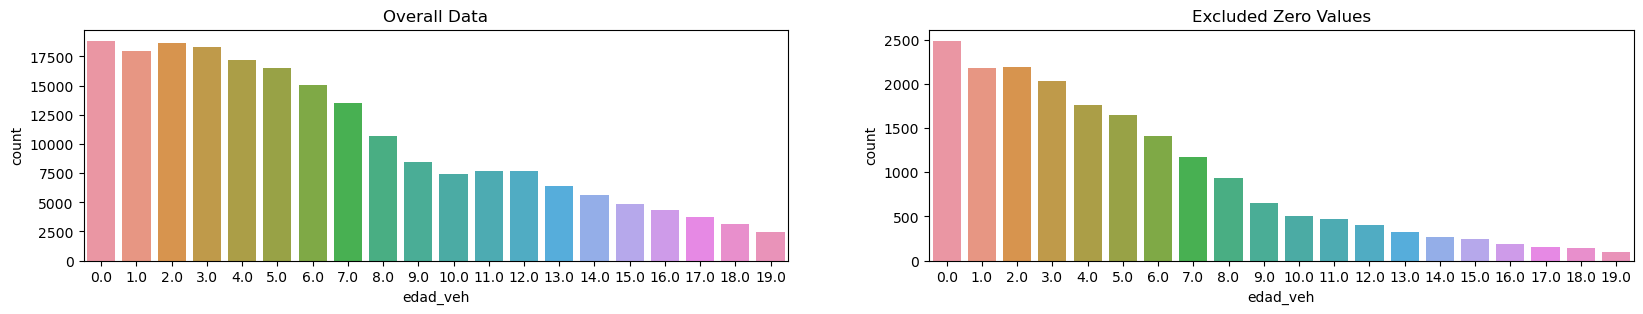

In [8]:
# Edad vehiculo

basico['edad_veh'] = pd.to_numeric(basico['edad_veh'], errors='coerce')
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,3)
g = sns.countplot(x='edad_veh',data=basico,ax=ax1)
title = g.set_title('Overall Data')
g = sns.countplot(x='edad_veh',data=basico[basico['Claim_Count']>0], ax=ax2)
title = g.set_title('Excluded Zero Values')

[Text(0, 0, 'F : 25 o menos'),
 Text(1, 0, 'F : 26-30'),
 Text(2, 0, 'F : 31-35'),
 Text(3, 0, 'F : 36-40'),
 Text(4, 0, 'F : 41-50'),
 Text(5, 0, 'F : 51-60'),
 Text(6, 0, 'F : >60'),
 Text(7, 0, 'M : 25 o menos'),
 Text(8, 0, 'M : 26-30'),
 Text(9, 0, 'M : 31-35'),
 Text(10, 0, 'M : 36-40'),
 Text(11, 0, 'M : 41-50'),
 Text(12, 0, 'M : 51-60'),
 Text(13, 0, 'M : >60'),
 Text(14, 0, 'NA')]

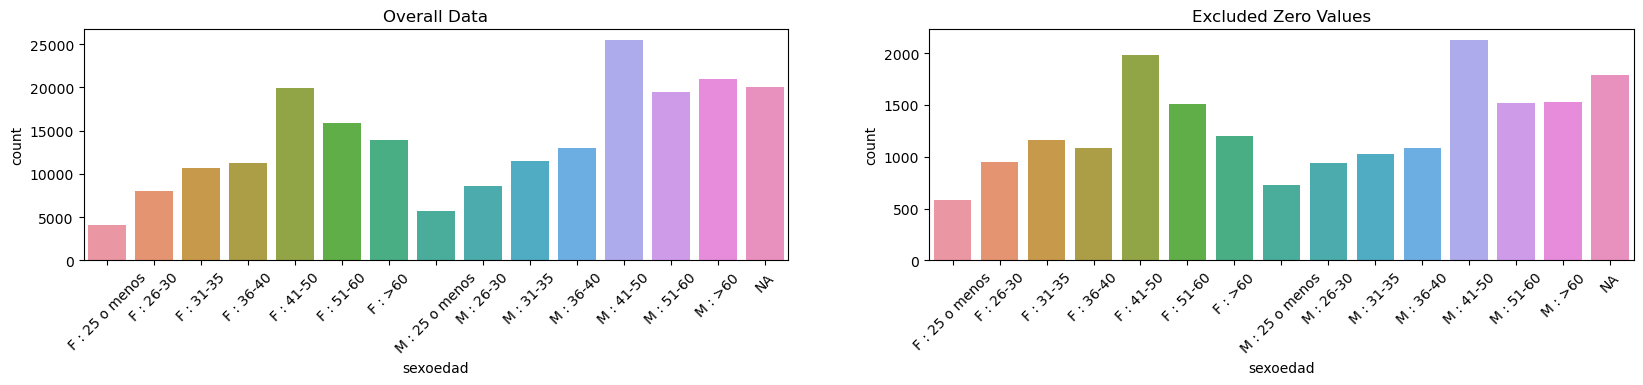

In [9]:
# Gender

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 3)
g1 = sns.countplot(x='sexoedad', data=basico.sort_values('sexoedad'), ax=ax1)
title = g1.set_title('Overall Data')
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
g = sns.countplot(x='sexoedad', data=basico[basico['Claim_Count'] > 0].sort_values('sexoedad'), ax=ax2)
title = g.set_title('Excluded Zero Values')
g.set_xticklabels(g.get_xticklabels(), rotation=45)


In [10]:
""" # 1. Cantidad de clientes únicos en la cartera total
clientes_totales = basico['COD_CLI'].nunique()

# 2. Cantidad de clientes únicos por año
clientes_por_año = basico.groupby('ANOVEH')['COD_CLI'].nunique()

# Imprime los resultados
print("Cantidad de Clientes Únicos en la Cartera Total:", clientes_totales)
print("Cantidad de Clientes Únicos por Año:")
print(clientes_por_año) """ 

' # 1. Cantidad de clientes únicos en la cartera total\nclientes_totales = basico[\'COD_CLI\'].nunique()\n\n# 2. Cantidad de clientes únicos por año\nclientes_por_año = basico.groupby(\'ANOVEH\')[\'COD_CLI\'].nunique()\n\n# Imprime los resultados\nprint("Cantidad de Clientes Únicos en la Cartera Total:", clientes_totales)\nprint("Cantidad de Clientes Únicos por Año:")\nprint(clientes_por_año) '

In [11]:
#  Count de marca_modelo
basico['MARCA_MODELO'] = basico['DESCMARCA']+'-'+ basico['DESCMODELO']
common_models_by_brand = basico.groupby(['MARCA_MODELO']).size().reset_index(name ='Count')
common_models_by_brand = common_models_by_brand.sort_values(by='Count', ascending=False)
common_models_by_brand.head(10)

,MARCA_MODELO,Count
422,HONDA-CRV,13161
1189,TOYOTA-HI LUX,9057
959,NISSAN-SENTRA,7883
1193,TOYOTA-LAND CRUISER PRADO,6260
1178,TOYOTA-COROLLA,6139
1213,TOYOTA-YARIS,5570
477,HYUNDAI-TUCSON,5464
900,MITSUBISHI-LANCER,5414
970,NISSAN-X-TRAIL,5149
1201,TOYOTA-RAV 4,5027


In [12]:
# 1. Modelos de automóviles más comunes por año con descripciones
año = 2021

common_models_by_year = basico.groupby(['ANOVEH', 'MARCA_MODELO']).size().reset_index(name='Count')
common_models_by_year = common_models_by_year[common_models_by_year['ANOVEH'] == año]
common_models_by_year = common_models_by_year.sort_values(by='Count', ascending=False)

# common_models_by_year = common_models_by_year.sort_values(by=['ANOVEH', 'Count'], ascending=[True, False])

# imprimir resultados
common_models_by_year

,ANOVEH,MARCA_MODELO,Count


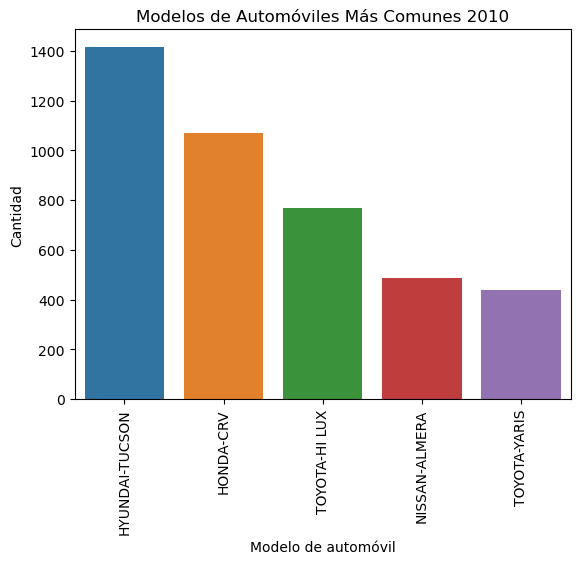

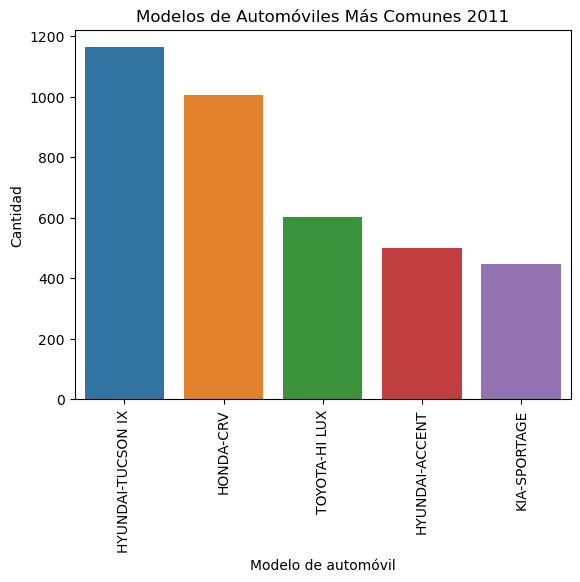

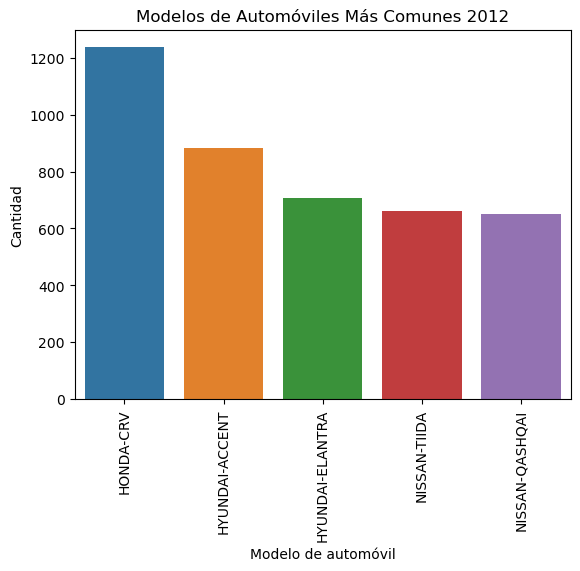

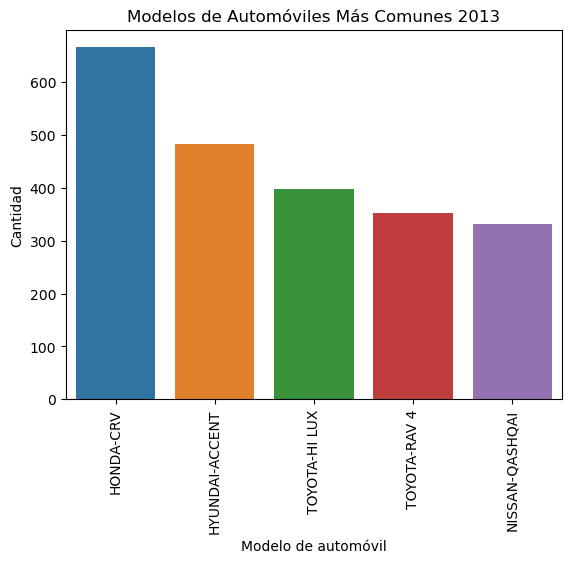

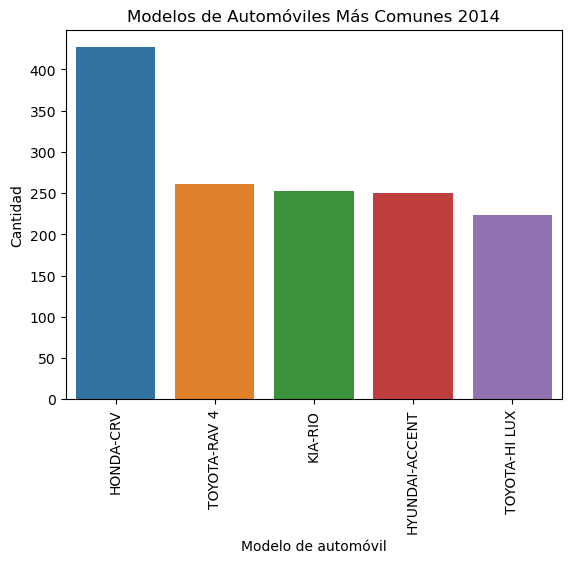

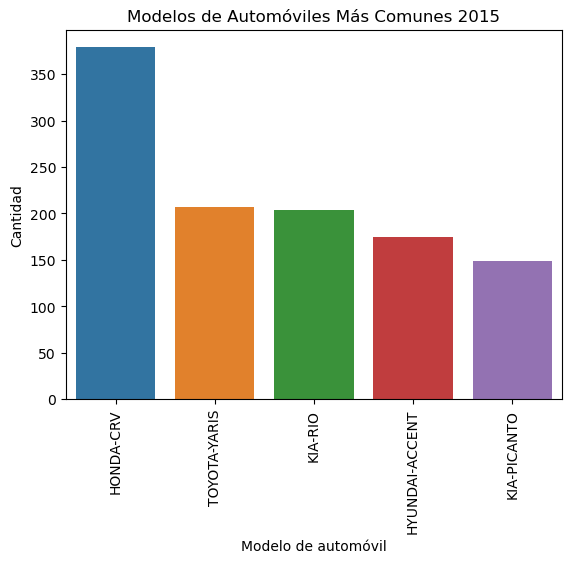

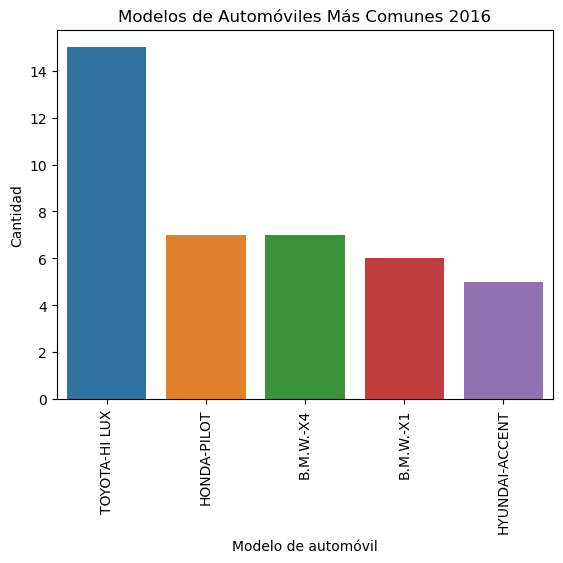

ValueError: min() arg is an empty sequence

<Figure size 640x480 with 0 Axes>

In [14]:
years = range(2010, 2024)  # List of years to plot

for año in years:
    common_models_by_year = basico.groupby(['ANOVEH', 'MARCA_MODELO']).size().reset_index(name='Count')
    common_models_by_year = common_models_by_year[common_models_by_year['ANOVEH'] == año]
    common_models_by_year = common_models_by_year.sort_values(by='Count', ascending=False).head(5)

    # Plotting the bar chart
    plt.figure()
    sns.barplot(x='MARCA_MODELO', y='Count', data=common_models_by_year)
    plt.title("Modelos de Automóviles Más Comunes " + str(año))
    plt.xlabel("Modelo de automóvil")
    plt.ylabel("Cantidad")
    plt.xticks(rotation=90)
    plt.show()

